# Serving for Data Analytics

In the first part of the lab, you ingested data from a source database and transformed it using AWS Glue. In this notebook, you will serve the transformed data for an analytics example. You will perform data retrieval with Amazon Athena using simple SQL queries and then use the query output to build an interactive dashboard that explores sales data by country and product line.

Import all of the required packages.

In [1]:
%pip install numpy==2.2.2
%pip install --upgrade boto3
%pip install --upgrade awswrangler
%pip install python-dotenv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 21.6 MB/s eta 0:00:00:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.0
    Uninstalling numpy-2.2.0:
      Successfully uninstalled numpy-2.2.0
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 18.8 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 MB 27.8 MB/s eta 0:00:0000:0100:01m
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
from dotenv import load_dotenv
import boto3
import pandas as pd
import awswrangler as wr
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import warnings


In [ ]:
load_dotenv()

aws_access_key  = os.environ.get('AWS_ACCESS_KEY')
aws_secret_access_key = os.environ.get('AWS_SECRET_ACCESS_KEY')

print(f"key: {aws_access_key}")

# Create a session with credentials and region
session = boto3.Session(
    aws_access_key_id=aws_access_key,
    aws_secret_access_key=aws_secret_access_key,
    region_name="us-east-1"
)

# Create an Athena client using the session
athena_client = session.client("athena")

After you have executed the AWS Glue job, a new database named `de-c1w2-analytics-db` was created and stored in the S3 instance. This database contains four tables with the following schema:

![image alt ><](./images/schema_after_ETL.png)

Each row in the `fact_orders` table corresponds to a sale order and contains related measurements such as quantity ordered and price. The dimension tables provide more context and details for each sale order such as customers' information, customers' locations, and order details. Your data is now ready to be served for analytics. To query this data from S3, you will use Amazon Athena. Let's check the data stored in the `dim_products` table:

In [4]:
GLUE_DATABASE = "de-c1w2-analytics-db"

products_df = wr.athena.read_sql_query(
    """
    SELECT * FROM dim_products
    """,
    database=GLUE_DATABASE,
    boto3_session=session,
)
    
products_df.head()

,productcode,productname,productline,productscale,productvendor,productdescription,productlinedescription
0,S18_2432,1926 Ford Fire Engine,Trucks and Buses,1:18,Carousel DieCast Legends,Gleaming red handsome appearance. Everything i...,The Truck and Bus models are realistic replica...
1,S18_4600,1940s Ford truck,Trucks and Buses,1:18,Motor City Art Classics,This 1940s Ford Pick-Up truck is re-created in...,The Truck and Bus models are realistic replica...
2,S32_3522,1996 Peterbilt 379 Stake Bed with Outrigger,Trucks and Buses,1:32,Red Start Diecast,"This model features, opening doors, detailed e...",The Truck and Bus models are realistic replica...
3,S12_4473,1957 Chevy Pickup,Trucks and Buses,1:12,Exoto Designs,"1:12 scale die-cast about 20"" long Hood opens,...",The Truck and Bus models are realistic replica...
4,S24_2300,1962 Volkswagen Microbus,Trucks and Buses,1:24,Autoart Studio Design,This 1:18 scale die cast replica of the 1962 M...,The Truck and Bus models are realistic replica...


You can get some data insights by aggregating some sale measurements from the fact table. In the following cell, you will compute the total sales amount spent by each country and display the top 10 records:

In [5]:
# Retrieve total sales per country by joining the 'fact_orders' table with 'dim_locations' on postal code.
# The result is grouped by the 'country' column, and the total sales for each country is calculated as the sum of order amounts.
# The query is executed using Athena through the 'wr.athena.read_sql_query' method, and the top 10 countries with the highest total sales are displayed.
product_sales_by_country_df = wr.athena.read_sql_query(
    """
    SELECT
        dim_locations.country,
        SUM(fact_orders.orderAmount) AS total_sales
    FROM
        fact_orders
    JOIN
        dim_locations ON fact_orders.postalCode = dim_locations.postalCode
    GROUP BY 1
    """,
    database=GLUE_DATABASE,
    boto3_session=session,
)
    
product_sales_by_country_df.sort_values("total_sales", ascending=False).head(10)

,country,total_sales
0,USA,13057249.77
2,Spain,1099389.09
15,France,1007374.02
17,Australia,562582.59
1,UK,436947.44
14,Italy,335258.49
18,Finland,295149.35
11,Singapore,263997.78
8,Denmark,218994.92
4,Canada,205911.86


Now you will combine data from three tables: `fact_orders`, `dim_products`, and `dim_locations`. The query will select the order date, product line, product name, country, and total sales amount, grouping the results by order date, product line, product name, and country:

In [6]:
# Retrieve detailed sales information by joining 'fact_orders' with 'dim_products' and 'dim_locations'.
# The query selects order date, product line, product name, country, and calculates the total sales (sum of order amounts).
# The result is grouped by order date, product line, product name, and country.
# The query is executed using Athena through the 'wr.athena.read_sql_query' method, and the resulting DataFrame is displayed with the first few rows using 'head()'.
product_sales_df = wr.athena.read_sql_query(
    """
    SELECT
        fact_orders.orderDate,
        dim_products.productLine,
        dim_products.productName,
        dim_locations.country,
        SUM(fact_orders.orderAmount) AS total_sales
    FROM
        fact_orders
    JOIN
        dim_products ON fact_orders.productCode = dim_products.productCode
    JOIN
        dim_locations ON fact_orders.postalCode = dim_locations.postalCode
    GROUP BY 1, 2, 3, 4
    """,
    database=GLUE_DATABASE,
    boto3_session=session,
)
    
product_sales_df.head()

,orderdate,productline,productname,country,total_sales
0,2004-06-15,Trucks and Buses,1996 Peterbilt 379 Stake Bed with Outrigger,Japan,1254.00
1,2005-01-26,Classic Cars,1969 Ford Falcon,Japan,4765.10
2,2004-11-23,Motorcycles,2003 Harley-Davidson Eagle Drag Bike,Japan,6948.63
3,2004-06-15,Trucks and Buses,1940 Ford Pickup Truck,Japan,4639.97
4,2005-01-26,Vintage Cars,1904 Buick Runabout,Japan,3238.59


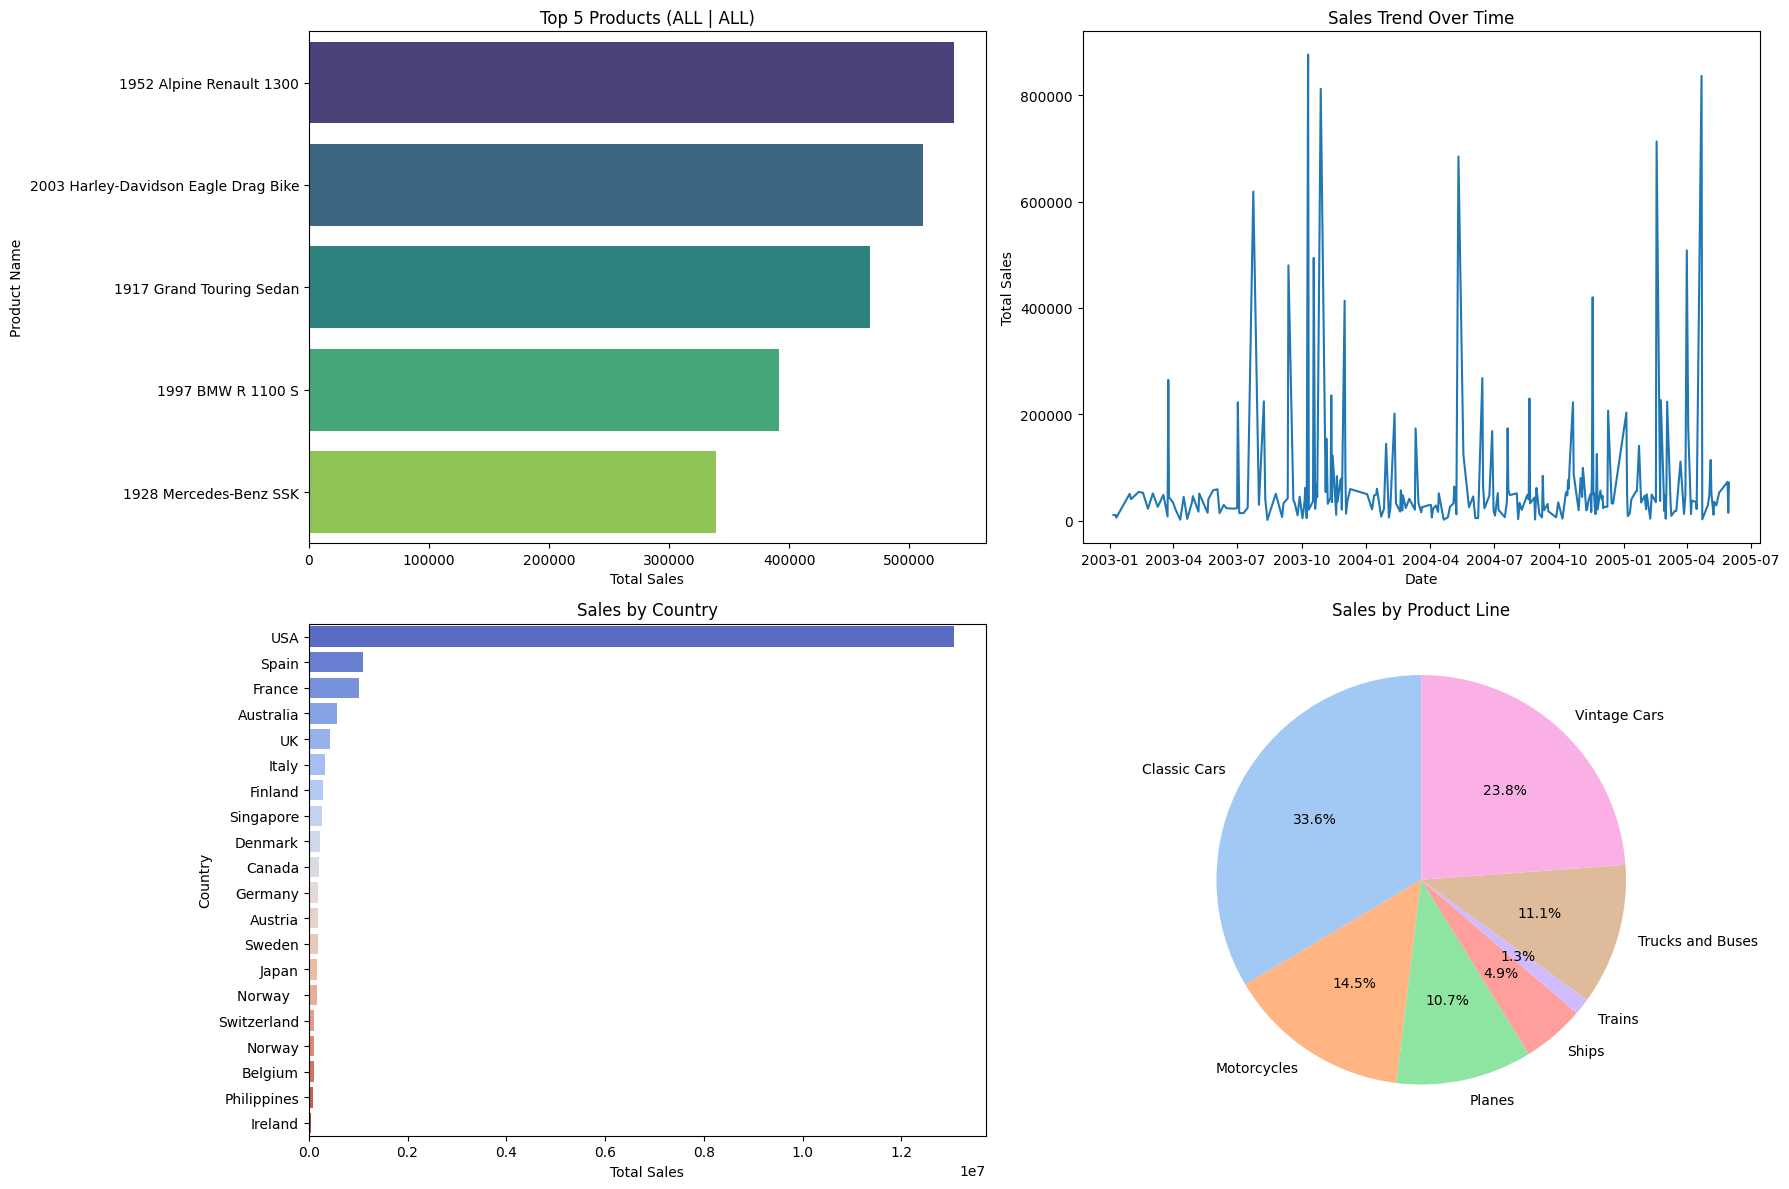


Dashboard Summary:
- Total Sales: 18840474.21
- Unique Products Sold: 109



In [7]:
# Ignore warnings for cleaner output
warnings.filterwarnings('ignore')

product_sales_df['orderdate'] = pd.to_datetime(product_sales_df['orderdate'], errors='coerce')

# Convert 'total_sales' to numeric
product_sales_df['total_sales'] = pd.to_numeric(product_sales_df['total_sales'], errors='coerce')

# Drop rows with NaN in 'total_sales'
product_sales_df = product_sales_df.dropna(subset=['total_sales'])

# Static Parameters for the Dashboard
start_date = product_sales_df['orderdate'].min()
end_date = product_sales_df['orderdate'].max()
selected_country = "ALL"  # Set to a specific country or "ALL"
selected_productline = "ALL"  # Set to a specific product line or "ALL"
top_n = 5  # Number of top products to display

# Step 1: Filter Data
filtered_df = product_sales_df.loc[
    (product_sales_df['orderdate'] >= pd.Timestamp(start_date)) &
    (product_sales_df['orderdate'] <= pd.Timestamp(end_date))
]

if selected_productline != "ALL":
    filtered_df = filtered_df[filtered_df['productline'] == selected_productline]
if selected_country != "ALL":
    filtered_df = filtered_df[filtered_df['country'] == selected_country]

# Step 2: Group and Aggregate Data
grouped_df = filtered_df.groupby(['productname'], as_index=False)['total_sales'].sum()
top_products = grouped_df.nlargest(top_n, 'total_sales')

# Create the dashboard with 4 charts
fig, axs = plt.subplots(2, 2, figsize=(18, 12))

# Chart 1: Top N Products
sns.barplot(
    x='total_sales',
    y='productname',
    data=top_products,
    ax=axs[0, 0],
    palette="viridis"
)
axs[0, 0].set_title(f"Top {top_n} Products ({selected_productline} | {selected_country})")
axs[0, 0].set_xlabel("Total Sales")
axs[0, 0].set_ylabel("Product Name")

# Chart 2: Sales Trend Over Time
sales_trend = filtered_df.groupby('orderdate', as_index=False)['total_sales'].sum()
sns.lineplot(
    data=sales_trend,
    x='orderdate',
    y='total_sales',
    ax=axs[0, 1]
)
axs[0, 1].set_title("Sales Trend Over Time")
axs[0, 1].set_xlabel("Date")
axs[0, 1].set_ylabel("Total Sales")

# Chart 3: Sales by Country
sales_by_country = filtered_df.groupby('country', as_index=False)['total_sales'].sum()
sns.barplot(
    x='total_sales',
    y='country',
    data=sales_by_country.sort_values('total_sales', ascending=False),
    ax=axs[1, 0],
    palette="coolwarm"
)
axs[1, 0].set_title("Sales by Country")
axs[1, 0].set_xlabel("Total Sales")
axs[1, 0].set_ylabel("Country")

# Chart 4: Sales by Product Line
sales_by_productline = filtered_df.groupby('productline', as_index=False)['total_sales'].sum()
axs[1, 1].pie(
    sales_by_productline['total_sales'],
    labels=sales_by_productline['productline'],
    autopct='%1.1f%%',
    colors=sns.color_palette("pastel"),
    startangle=90
)
axs[1, 1].set_title("Sales by Product Line")

# Adjust layout
plt.tight_layout()

# Show the dashboard
plt.show()

# Step 4: Additional Summary Statistics
total_sales = filtered_df['total_sales'].sum()
unique_products = filtered_df['productname'].nunique()
summary = f"""
Dashboard Summary:
- Total Sales: {total_sales}
- Unique Products Sold: {unique_products}
"""

print(summary)


You will now use the query results to build an interactive dashboard using dropdown widgets, where you will be able to select a country and product line, filter the results based on a particular period of sales, showing the top N popular products at the end:

Fantastic! You can now observe how effortlessly the data can be accessed after having transformed it into a form that is more appropriate for analytics.